#### These notebooks need the Kather2016 images in the same folder to run. The training/validation images weren't submitted due to their size. If you wish to run the code please add the images.

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.applications import VGG16
import os

h, w = 150, 150   #specify height and width of the images
root_dir = '/home/annika/Computational_Biology_Second_Bit/Assignment3/notebooks/Kather_2016_images'  #give directories
train_dir = os.path.join(root_dir,'Training')
val_dir = os.path.join(root_dir,'Validation')

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(h,w,3)) #load vgg16, exclude the top

my_input = Input(shape=(h,w,3))        
temp = vgg_model.layers[1](my_input)
for layer in vgg_model.layers[2:]:
    temp = layer(temp)
temp = Flatten()(temp)                #keep everything up to flatten
temp = Dense(256,activation='relu')(temp)  #add Dense layer with relu activation function
temp = Dropout(0.5)(temp)                  #add dropout layer
my_output = Dense(8,activation='softmax')(temp)  #add softmax layer

my_model = Model(my_input,my_output)       #build new model

print(my_model.summary())

/home/annika/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [2]:
for layer in my_model.layers:              #freeze parameters up to flatten
    if 'dense' not in layer.name:
        layer.trainable = False
    else:
        break

In [3]:
for layer in my_model.layers:           # check trainability
    x = layer.trainable
    print(layer.name, x)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten_1 False
dense_1 True
dropout_1 True
dense_2 True


In [4]:
my_model.compile(loss='categorical_crossentropy',       #compile the model, loss:crossentropy
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [5]:
datagen = ImageDataGenerator(rescale=1./255)           #define data generator

In [6]:
train_generator = datagen.flow_from_directory(       #generate training and validation data
    train_dir,
    target_size=(h, w),
    batch_size=128)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(h, w),
    batch_size =128)

Found 4164 images belonging to 8 classes.
Found 836 images belonging to 8 classes.


In [7]:
print(train_generator.class_indices)        #check classes
print(validation_generator.class_indices)

{'06_MUCOSA': 5, '07_ADIPOSE': 6, '08_EMPTY': 7, '02_STROMA': 1, '03_COMPLEX': 2, '05_DEBRIS': 4, '01_TUMOR': 0, '04_LYMPHO': 3}
{'06_MUCOSA': 5, '07_ADIPOSE': 6, '08_EMPTY': 7, '02_STROMA': 1, '03_COMPLEX': 2, '05_DEBRIS': 4, '01_TUMOR': 0, '04_LYMPHO': 3}


In [8]:
# fine-tune the model, use model fit generators (whole data)
epochs = 5
my_model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)

Epoch 1/5
33/33 [==============================] - 526s 16s/step - loss: 1.0154 - acc: 0.6520 - val_loss: 0.6102 - val_acc: 0.7955
Epoch 2/5
33/33 [==============================] - 533s 16s/step - loss: 0.5070 - acc: 0.8236 - val_loss: 0.4269 - val_acc: 0.8624
Epoch 3/5
33/33 [==============================] - 535s 16s/step - loss: 0.4188 - acc: 0.8555 - val_loss: 0.4546 - val_acc: 0.8553
Epoch 4/5
33/33 [==============================] - 535s 16s/step - loss: 0.3619 - acc: 0.8751 - val_loss: 0.3588 - val_acc: 0.8828
Epoch 5/5
33/33 [==============================] - 526s 16s/step - loss: 0.3167 - acc: 0.8894 - val_loss: 0.3705 - val_acc: 0.8684


In [9]:
my_model.save('vgg_fine_tuned.h5')   #save (import later in Matlab)

USE THE MODEL

In [10]:
import sklearn
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [11]:
prediction_generator = datagen.flow_from_directory(     #define prediction generator
    val_dir,
    target_size=(h, w),
    batch_size =128,
    shuffle=False)

Found 836 images belonging to 8 classes.


In [12]:
predict = my_model.predict_generator(prediction_generator,verbose=1)    #predict validatiton data

7/7 [==============================] - 88s 13s/step


In [13]:
predict = np.argmax(predict, axis = 1)   #transform back from one-hot-encoded
print(predict.shape)

(836,)


In [14]:
val_true = prediction_generator.classes    #get the true labels

In [15]:
print(val_true.shape)  #check the shape matches

(836,)


In [16]:
Confusion = sklearn.metrics.confusion_matrix(val_true, predict, labels=None, sample_weight=None)  #compute confusion matrix

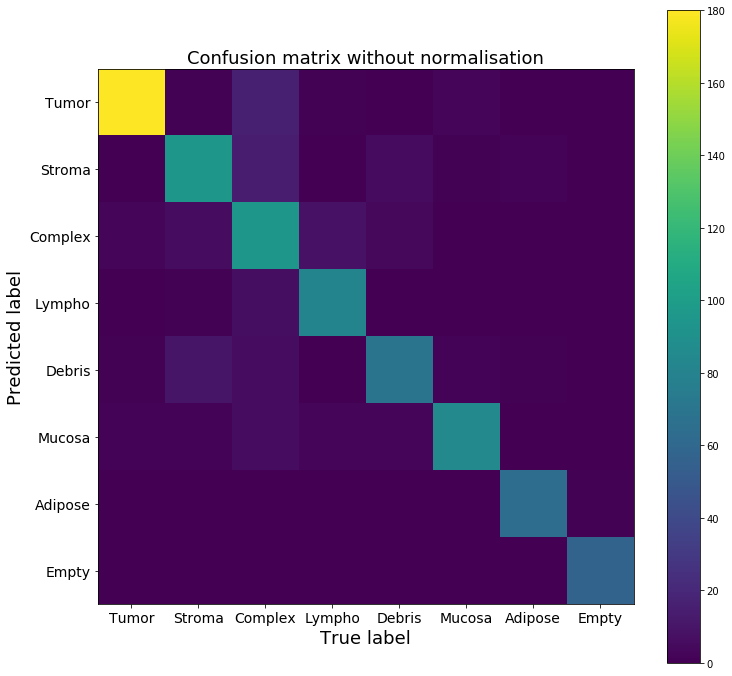

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
heatmap = ax.imshow(Confusion)
cbar = fig.colorbar(heatmap)


labels = ["Tumor","Stroma","Complex","Lympho","Debris","Mucosa","Adipose","Empty"]
ax.set_xticks(range(8))
ax.set_yticks(range(8))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
        
plt.title('Confusion matrix without normalisation',fontsize=18)
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)
